<a href="https://colab.research.google.com/github/utkarshsharma1/ECG_Signals/blob/master/Utkarsh_koen_aerts_ECG_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

!pip install pyyaml h5py  # Required to save models in HDF5 format

TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
import math
import seaborn as sns

In [0]:
!pip install wfdb
import wfdb              # much needed for annotations


!pip install biosppy
from biosppy.signals import ecg
from scipy import signal

     |████████████████████████████████| 102kB 3.2MB/s 
     |████████████████████████████████| 163kB 8.3MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-cp36-none-any.whl size=100368 sha256=c8cefff0c44ddc14a2684811d795f03feb3d2a1b04afb0e486d21edbe633c631
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
Successfully built wfdb
     |████████████████████████████████| 81kB 2.3MB/s 


In [0]:
import tensorflow as tf

#tf.logging.set_verbosity(tf.logging.INFO)
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
sample_database = ['100', '101', '102', '103', '104', '105', '106', '107', '108', 
                   '109', '111', '112', '113', '114', '115', '116', '117', '118',
                   '119', '121', '122', '123', '124', '200', '201', '202', '203',
                   '205', '207', '208', '209', '210', '212', '213', '214', '215',
                   '217', '219', '220', '221', '222', '223', '228', '230', '231',
                   '232', '233', '234']

#abnormal = ['L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']
abnormal = ['L', 'R', 'V', '/']

In [0]:
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/data_ecg/'):
    os.mkdir('/content/drive/My Drive/Colab Notebooks/data_ecg/')

for path in sample_database:

    print(path)

    # Read in the data
    record = wfdb.rdsamp(path, pb_dir= 'mitdb')
    annotation = wfdb.rdann(path, 'atr', pb_dir= 'mitdb')
    
    # Get the ECG values from the file.
    data = record[0].transpose()

    category = np.array(annotation.symbol)
    rate = np.zeros_like(category, dtype='float')
    for catid, catval in enumerate(category):
        if (catval == 'N'):
            rate[catid] = 1         # Normal
        elif (catval in abnormal):
            rate[catid] = abnormal.index(catval) + 2      # Abnormal
    rates = np.zeros_like(data[0], dtype='float')
    rates[annotation.sample] = rate
    
    indices = np.arange(data[0].size, dtype='int')

    # Process each channel separately (2 per input file).
    for channelid, channel in enumerate(data):
        chname = record[1].get('sig_name')[channelid]
        
        # Find rpeaks in the ECG data. Most should match with
        # the annotations.
        out = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        rpeaks = np.zeros_like(channel, dtype='float')
        rpeaks[out['rpeaks']] = 1.0
        
        beatstoremove = np.array([0])

        # Split into individual heartbeats. For each heartbeat
        # record, append classification (normal/abnormal).
        beats = np.split(channel, out['rpeaks'])
        for idx, idxval in enumerate(out['rpeaks']):
            firstround = idx == 0
            lastround = idx == len(beats) - 1

            # Skip first and last beat.
            if (firstround or lastround):
                continue

            # Get the classification value that is on
            # or near the position of the rpeak index.
            fromidx = 0 if idxval < 10 else idxval - 10
            toidx = idxval + 10
            catval = rates[fromidx:toidx].max()

            # Skip beat if there is no classification.
            if (catval == 0.0):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Normal beat is now classified as 0.0 and abnormal is 1.0.
            catval = catval - 1.0

            # Append some extra readings from next beat.
            beats[idx] = np.append(beats[idx], beats[idx+1][:40])

            # Normalize the readings to a 0-1 range for ML purposes.
            beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

            # Resample from 360Hz to 125Hz
            newsize = int((beats[idx].size * 125 / 360) + 0.5)
            beats[idx] = signal.resample(beats[idx], newsize)

            # Skipping records that are too long.
            if (beats[idx].size > 187):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Pad with zeroes.
            zerocount = 187 - beats[idx].size
            beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

            # Append the classification to the beat data.
            beats[idx] = np.append(beats[idx], catval)

        beatstoremove = np.append(beatstoremove, len(beats)-1)

        # Remove first and last beats and the ones without classification.
        beats = np.delete(beats, beatstoremove)

        # Save to CSV file.
        savedata = np.array(list(beats[:]), dtype=np.float)
        outfn = '/content/drive/My Drive/Colab Notebooks/data_ecg/'+ path + '_'+ chname + '.csv'
        print(' Generating ', outfn)
        with open(outfn, "wb") as fin:
            np.savetxt(fin, savedata, delimiter=",", fmt='%f')

100
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/100_MLII.csv
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/100_V5.csv
101
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/101_MLII.csv
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/101_V1.csv
102
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/102_V5.csv
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/102_V2.csv
103
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/103_MLII.csv
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/103_V2.csv
104
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/104_V5.csv
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/104_V2.csv
105
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/105_MLII.csv
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/105_V1.csv
106
 Generating  /content/drive/My Drive/Colab Notebooks/data_ecg/106_MLII.csv
 Generating  

In [0]:
data = np.loadtxt('/content/drive/My Drive/Colab Notebooks/data_ecg/232_V1.csv', delimiter=',')
print(data.shape)

(0,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: loadtxt: Empty input file: "/content/drive/My Drive/Colab Notebooks/data_ecg/232_V1.csv"
  """Entry point for launching an IPython kernel.


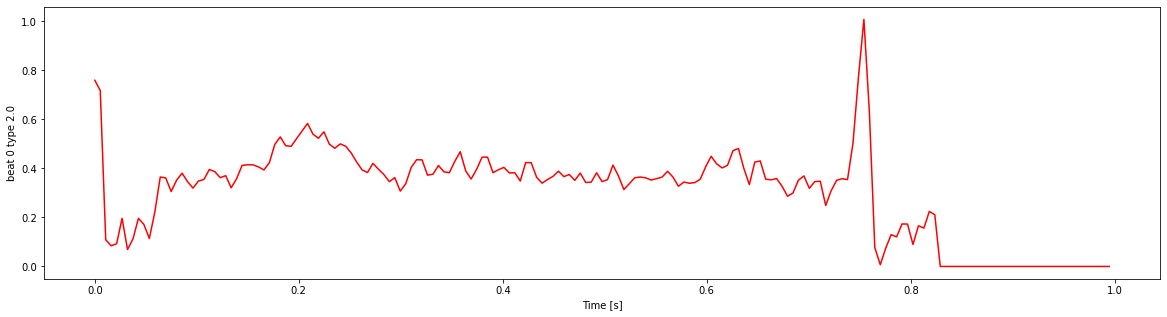

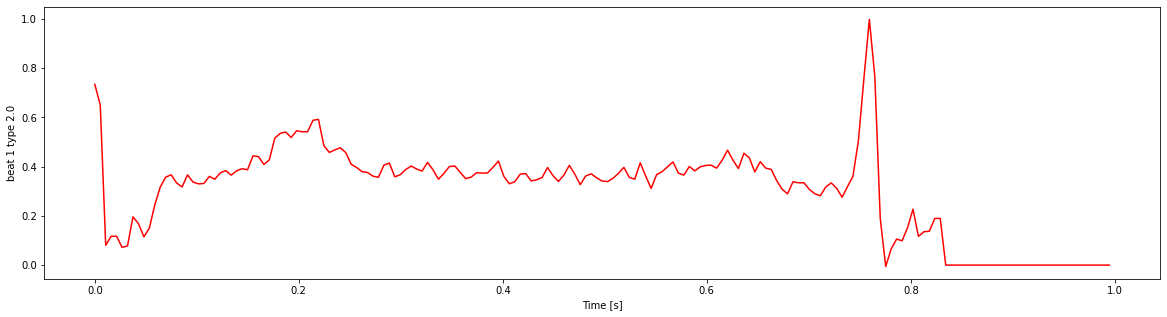

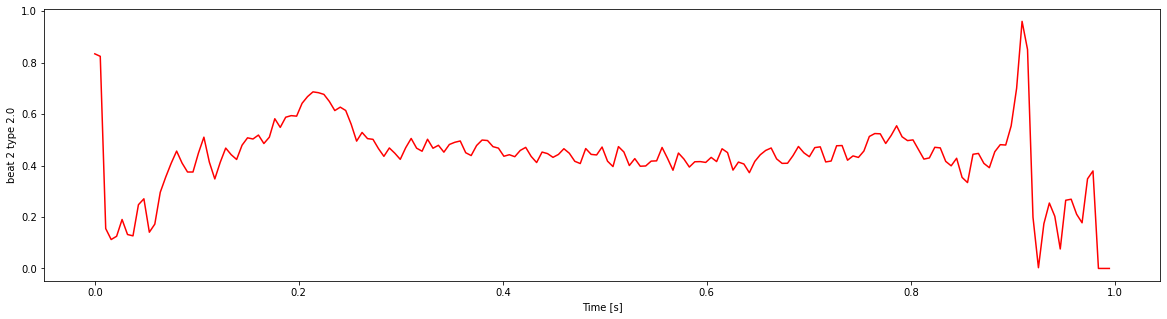

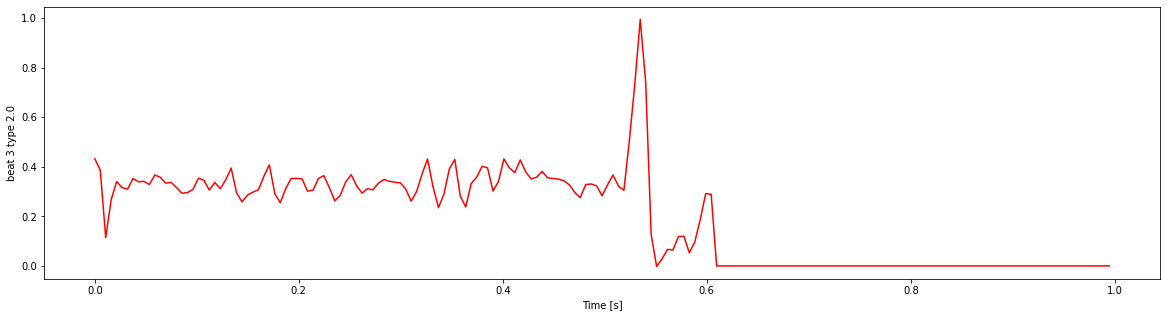

IndexError: ignored

In [0]:
for beatid in [0,1,2,3,99,200,502,2428,2443]:
    times = np.arange(187, dtype = 'float') / 187
    beat = data[beatid][:-1]
    anno = data[beatid][-1]
    plt.figure(figsize=(20,5))
    if (anno == 0.0):
      plt.plot(times, beat, 'b')
    else:
      plt.plot(times, beat, 'r')
    plt.xlabel('Time [s]')
    plt.ylabel('beat ' + str(beatid) + " type " + str(anno))
    plt.show()

#Load data

In [0]:
alldata = np.empty(shape=[0, 188])
print(alldata.shape)
paths = glob('/content/drive/My Drive/Colab Notebooks/data_ecg/*.csv')
for path in paths:
    print('Loading ', path)
    try:
      csvrows = np.loadtxt(path, delimiter=',')
      alldata = np.append(alldata, csvrows, axis=0)
    except:
      print("Error")

(0, 188)
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/100_MLII.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/100_V5.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/101_MLII.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/101_V1.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/102_V5.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/102_V2.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/103_MLII.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/103_V2.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/104_V5.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/104_V2.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/105_MLII.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/105_V1.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/106_MLII.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/106_V1.csv
Loading  /conte

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: loadtxt: Empty input file: "/content/drive/My Drive/Colab Notebooks/data_ecg/232_V1.csv"
  import sys


Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/233_V1.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/234_MLII.csv
Loading  /content/drive/My Drive/Colab Notebooks/data_ecg/234_V1.csv


In [0]:
alldata.shape

(143103, 188)

In [0]:
# Randomly mix rows
np.random.shuffle(alldata)
totrows = len(alldata)
trainrows = int((totrows * 3 / 5) + 0.5) # 60%
testrows = int((totrows * 1 / 5) + 0.5) # 20%
validaterows = totrows - trainrows - testrows # 20%
mark1 = trainrows
mark2 = mark1 + testrows

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/data_ecg/train.csv', "wb") as fin:
    np.savetxt(fin, alldata[:mark1], delimiter=",", fmt='%f')

with open('/content/drive/My Drive/Colab Notebooks/data_ecg/test.csv', "wb") as fin:
    np.savetxt(fin, alldata[mark1:mark2], delimiter=",", fmt='%f')

with open('/content/drive/My Drive/Colab Notebooks/data_ecg/validate.csv', "wb") as fin:
    np.savetxt(fin, alldata[mark2:], delimiter=",", fmt='%f')

#Model training

In [0]:
# Training dataset.
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data_ecg/train.csv", header=None)
x_train = df.values[:, :-1]
y_train = df.values[:, -1].astype(int)

# Validation dataset.
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data_ecg/validate.csv", header=None)
x_validate = df.values[:, :-1]
y_validate = df.values[:, -1].astype(int)

# Test dataset.
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data_ecg/test.csv", header=None)
x_test = df.values[:, :-1]
y_test = df.values[:, -1].astype(int)

In [0]:
print(np.unique(y_train, return_counts = True))
print(np.unique(y_validate, return_counts = True))
print(np.unique(y_test, return_counts = True))
#print(x_test.shape, y_test.shape)
#print(x_validate.shape, y_validate.shape)
#print(x_test.shape, y_train.shape)

print(np.unique(y_train, return_counts = True) + np.unique(y_validate, return_counts = True) + np.unique(y_test, return_counts = True))

(array([0, 1, 2, 3, 4]), array([67437,  3905,  5799,  2891,  5830]))
(array([0, 1, 2, 3, 4]), array([22497,  1346,  1896,   951,  1930]))
(array([0, 1, 2, 3, 4]), array([22513,  1315,  1890,   941,  1962]))
(array([0, 1, 2, 3, 4]), array([67437,  3905,  5799,  2891,  5830]), array([0, 1, 2, 3, 4]), array([22497,  1346,  1896,   951,  1930]), array([0, 1, 2, 3, 4]), array([22513,  1315,  1890,   941,  1962]))


In [0]:
a = np.unique(y_test, return_counts = True)
print(a[1])

[22513  1315  1890   941  1962]


In [0]:
del df

In [0]:
C0 = np.argwhere(y_train == 0).flatten()
C1 = np.argwhere(y_train == 1).flatten()
C2 = np.argwhere(y_train == 2).flatten()
C3 = np.argwhere(y_train == 3).flatten()
C4 = np.argwhere(y_train == 4).flatten()

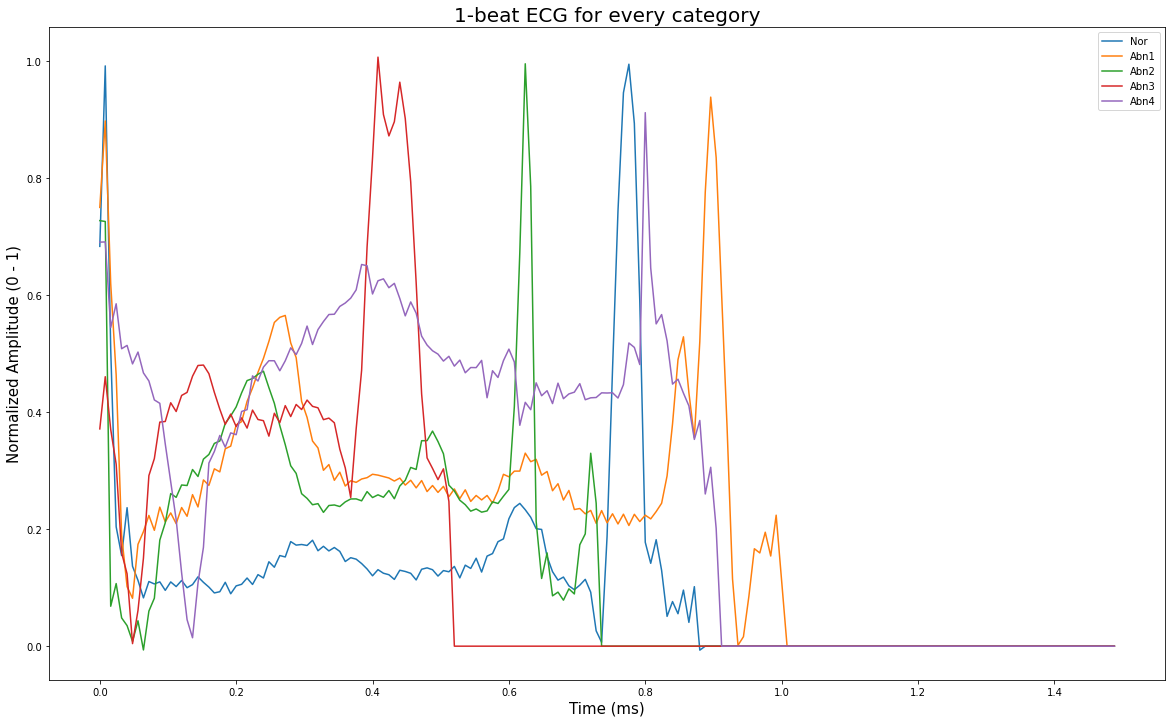

In [0]:
x = np.arange(0, 187)*8/1000.0

plt.figure(figsize=(20,12))
plt.plot(x, x_train[C0, :][0], label="Nor") # Display first normal beat.
plt.plot(x, x_train[C1, :][0], label="Abn1") # Display first abnormal beat.
plt.plot(x, x_train[C2, :][0], label="Abn2") # Display first abnormal beat.
plt.plot(x, x_train[C3, :][0], label="Abn3") # Display first abnormal beat.
plt.plot(x, x_train[C4, :][0], label="Abn4") # Display first abnormal beat.

plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Normalized Amplitude (0 - 1)", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

In [0]:
feature_columns = [tf.feature_column.numeric_column('beat', shape=[187])]

estimator = tf.estimator.DNNClassifier(
   feature_columns = feature_columns,
   hidden_units = [256, 64, 16],
   optimizer = tf.optimizers.Adam(1e-4),
   n_classes = 5,
   dropout = 0.1,
   model_dir = '/content/drive/My Drive/Colab Notebooks/ecg_model'
)

input_fn_train = tf.compat.v1.estimator.inputs.numpy_input_fn(
    x = {'beat': x_train},
    y = y_train,
    num_epochs = None,
    batch_size = 50,
    shuffle = True
)

In [0]:
estimator.train(input_fn = input_fn_train, steps=400000) 

In [0]:
input_fn_validate = tf.compat.v1.estimator.inputs.numpy_input_fn(
    x = {'beat': x_validate},
    y=y_validate,
    num_epochs=1,
    shuffle=False
)

In [0]:
accuracy_score = estimator.evaluate(input_fn=input_fn_validate)
print('\nTest Accuracy: {0:f}%\n'.format(accuracy_score['accuracy']*100))


Test Accuracy: 99.203354%



In [0]:
input_fn_test = tf.compat.v1.estimator.inputs.numpy_input_fn(
 x={'beat': x_test},
 y=y_test,
 num_epochs=1,
 shuffle=False
)

In [0]:
predictions = estimator.predict(input_fn=input_fn_test)

In [0]:
totvals = 0
totwrong = 0

for prediction, expected in zip(predictions, y_test):
    totvals = totvals + 1
    catpred = prediction['class_ids'][0]
    certainty = prediction['probabilities'][catpred] * 100
    if (expected != catpred):
        totwrong = totwrong + 1
        #print (prediction)
        print('Real: ', expected, ', pred: ', catpred, ', cert: ', certainty)

print('Accuracy: ', ((totvals - totwrong) * 100.0 / totvals))
print('Wrong: ', totwrong, ' out of ', totvals)

Real:  3 , pred:  0 , cert:  99.39026832580566
Real:  3 , pred:  0 , cert:  76.35917067527771
Real:  2 , pred:  0 , cert:  83.0461859703064
Real:  0 , pred:  2 , cert:  74.12071228027344
Real:  0 , pred:  3 , cert:  65.74440002441406
Real:  4 , pred:  0 , cert:  95.9308922290802
Real:  0 , pred:  2 , cert:  83.0263078212738
Real:  3 , pred:  4 , cert:  94.24446821212769
Real:  1 , pred:  0 , cert:  99.99946355819702
Real:  3 , pred:  0 , cert:  99.77204203605652
Real:  2 , pred:  0 , cert:  99.99836683273315
Real:  0 , pred:  3 , cert:  99.80777502059937
Real:  3 , pred:  0 , cert:  99.9182641506195
Real:  0 , pred:  3 , cert:  77.8688907623291
Real:  0 , pred:  4 , cert:  95.72435021400452
Real:  0 , pred:  3 , cert:  99.30335283279419
Real:  0 , pred:  3 , cert:  90.40619134902954
Real:  1 , pred:  0 , cert:  94.30714249610901
Real:  0 , pred:  1 , cert:  98.13007116317749
Real:  0 , pred:  3 , cert:  99.28761720657349
Real:  3 , pred:  0 , cert:  100.0
Real:  3 , pred:  0 , cert:  6

#Our cnn model


In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, Input, Softmax, Add, Activation

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical


In [0]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_validate = np.reshape(x_validate, (x_validate.shape[0], x_validate.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape, x_validate.shape, x_test.shape)

(85862, 187, 1) (28620, 187, 1) (28621, 187, 1)


In [0]:
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)
y_test = to_categorical(y_test)

In [0]:
print(y_train.shape, y_validate.shape, y_test.shape)

(85862, 5) (28620, 5) (28621, 5)


In [0]:
n_obs, feature, depth = x_train.shape
batch_size = 500

In [0]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      5152        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 183, 32)      0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [0]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [0]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = adam,
    metrics = ['accuracy']
)

In [0]:
history = model.fit(x_train, y_train, 
                    epochs = 10, 
                    batch_size = batch_size, 
                    verbose = 1,
                    validation_data = (x_validate, y_validate), 
                    callbacks=[lrate])

Train on 85862 samples, validate on 28620 samples
Epoch 1/10
85862/85862 [==============================] - 88s 1ms/sample - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0127 - val_accuracy: 0.9964
Epoch 2/10
85862/85862 [==============================] - 88s 1ms/sample - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.0170 - val_accuracy: 0.9954
Epoch 3/10
85862/85862 [==============================] - 87s 1ms/sample - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.0136 - val_accuracy: 0.9964
Epoch 4/10
85862/85862 [==============================] - 87s 1ms/sample - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.0140 - val_accuracy: 0.9965
Epoch 5/10
85862/85862 [==============================] - 87s 1ms/sample - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.0140 - val_accuracy: 0.9966
Epoch 6/10
85862/85862 [==============================] - 87s 1ms/sample - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0147 - val_accuracy: 0.9963
Epoch 7/10
85862/85862 [==============================] 

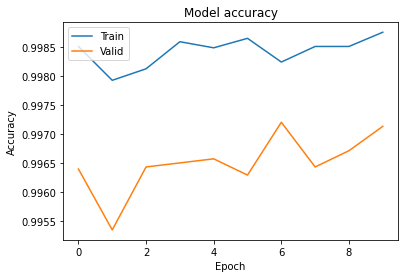

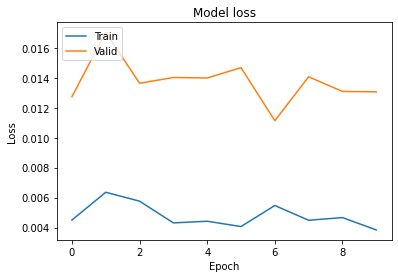

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [0]:
y_train_preds = model.predict(x_train, verbose = 1)
y_validate_preds = model.predict(x_validate, verbose = 1)
y_test_preds = model.predict(x_test)

28620/28620 [==============================] - 9s 325us/sample


In [0]:
y_test_preds[0]

array([1.0000000e+00, 8.7685941e-16, 7.3693185e-24, 7.5506177e-15,
       2.1419553e-22], dtype=float32)

In [0]:
# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [0]:
y_train_preds = [np.argmax(i) for i in y_train_preds ]
y_train = [np.argmax(i) for i in y_train ]

results = confusion_matrix(y_train, y_train_preds) 
  
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_train, y_train_preds))
print ('Report : ')
print (classification_report(y_train, y_train_preds)) 

Confusion Matrix :
[[67411     1     0    25     0]
 [    1  3904     0     0     0]
 [    2     0  5797     0     0]
 [    9     0     0  2882     0]
 [    1     2     0     7  5820]]
Accuracy Score : 0.9994409634063963
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67437
           1       1.00      1.00      1.00      3905
           2       1.00      1.00      1.00      5799
           3       0.99      1.00      0.99      2891
           4       1.00      1.00      1.00      5830

    accuracy                           1.00     85862
   macro avg       1.00      1.00      1.00     85862
weighted avg       1.00      1.00      1.00     85862



In [0]:
y_validate_preds = [np.argmax(i) for i in y_validate_preds ]
y_validate = [np.argmax(i) for i in y_validate]

results = confusion_matrix(y_validate, y_validate_preds) 
  
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_validate, y_validate_preds))
print ('Report : ')
print (classification_report(y_validate, y_validate_preds)) 

Confusion Matrix :
[[22457     0     3    36     1]
 [    4  1341     0     1     0]
 [    8     1  1884     3     0]
 [   19     4     0   928     0]
 [    2     0     0     0  1928]]
Accuracy Score : 0.9971348707197764
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22497
           1       1.00      1.00      1.00      1346
           2       1.00      0.99      1.00      1896
           3       0.96      0.98      0.97       951
           4       1.00      1.00      1.00      1930

    accuracy                           1.00     28620
   macro avg       0.99      0.99      0.99     28620
weighted avg       1.00      1.00      1.00     28620



In [0]:
y_test_preds = [np.argmax(i) for i in y_test_preds ]
y_test = [np.argmax(i) for i in y_test ]

results = confusion_matrix(y_test, y_test_preds) 
  
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_test_preds))
print ('Report : ')
print (classification_report(y_test, y_test_preds)) 

Confusion Matrix :
[[22477     1     0    35     0]
 [    4  1310     0     1     0]
 [    4     1  1884     1     0]
 [   31     0     0   910     0]
 [    3     2     0     3  1954]]
Accuracy Score : 0.9969952133049159
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22513
           1       1.00      1.00      1.00      1315
           2       1.00      1.00      1.00      1890
           3       0.96      0.97      0.96       941
           4       1.00      1.00      1.00      1962

    accuracy                           1.00     28621
   macro avg       0.99      0.99      0.99     28621
weighted avg       1.00      1.00      1.00     28621



In [0]:
def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

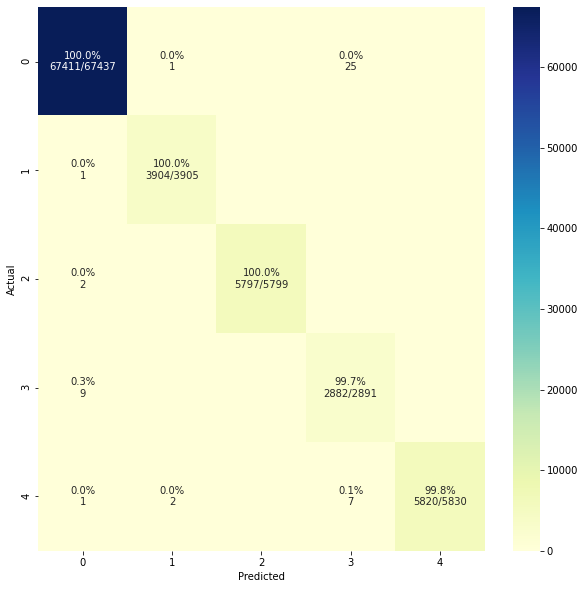

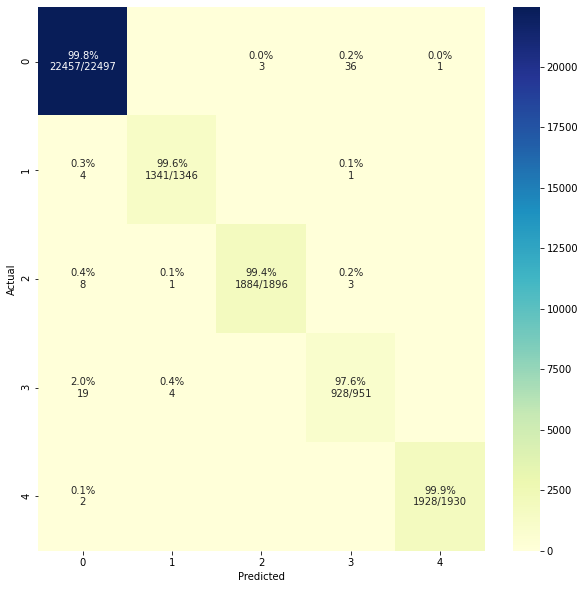

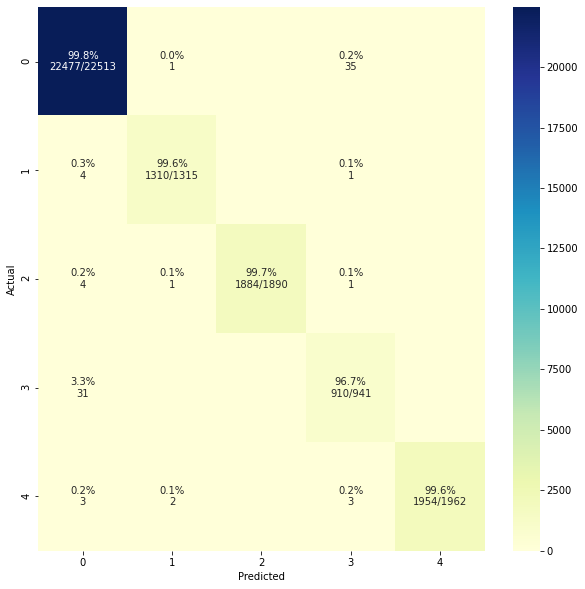

In [0]:
plot_cm(y_train, y_train_preds)
plot_cm(y_validate, y_validate_preds)
plot_cm(y_test, y_test_preds)